In [61]:
import os

import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

sns.set()
%matplotlib inline

In [6]:
path = os.path.join('..', 'cache')
filename = 'train.csv'
filepath = os.path.join(path, filename)
filepath

'../cache/train.csv'

In [7]:
!ls {path}

test.csv  train.csv


In [8]:
df_train = pd.read_csv(os.path.join(path, 'train.csv'))
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [9]:
df_test =  pd.read_csv(os.path.join(path, 'test.csv'))
df_test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [10]:
df_train.shape

(1306122, 3)

In [11]:
np.unique(df_train['target'])

array([0, 1])

In [12]:
len(df_train)

1306122

In [13]:
df_train['target'].mean()

0.06187017751787352

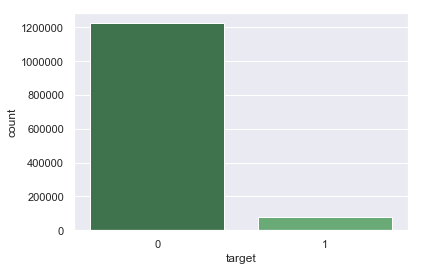

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x="target", data=df_train, palette="Greens_d");

*df_train unbalanced : only 6% of dataset vith positive values*

In [15]:
df_train.loc[df_train['target'] == 1].head()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


In [16]:
X = df_train.loc[:, 'question_text']
y = df_train.loc[:, 'target']
X.shape, y.shape

((1306122,), (1306122,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((653061,), (653061,), (653061,), (653061,))

In [18]:
X_train.head()

130809     Why did you become a data science manager and ...
36523      Is it true that Mexicans are treated like seco...
1109227    Why should I not see a psychiatrist who is rel...
349685       Why does China want to capture other countries?
341120     What has been your best patient interaction as...
Name: question_text, dtype: object

In [19]:
df_train1 = df_train[df_train["target"]==1]
df_train0 = df_train[df_train["target"]==0]

In [20]:
len(df_train1['question_text'])

80810

In [21]:
len(df_train0['question_text'])

1225312

In [22]:
len(df_train.loc[df_train['target'] == 1]['question_text'])

80810

In [23]:
#text = str(df_train['question_text'])
text_insincere = str(df_train1['question_text'])
len(text_insincere)

3770

In [77]:
df_train["quest_len"] = df_train["question_text"].apply(lambda x: len(x))

In [85]:
df_train["quest_len"][0]

72

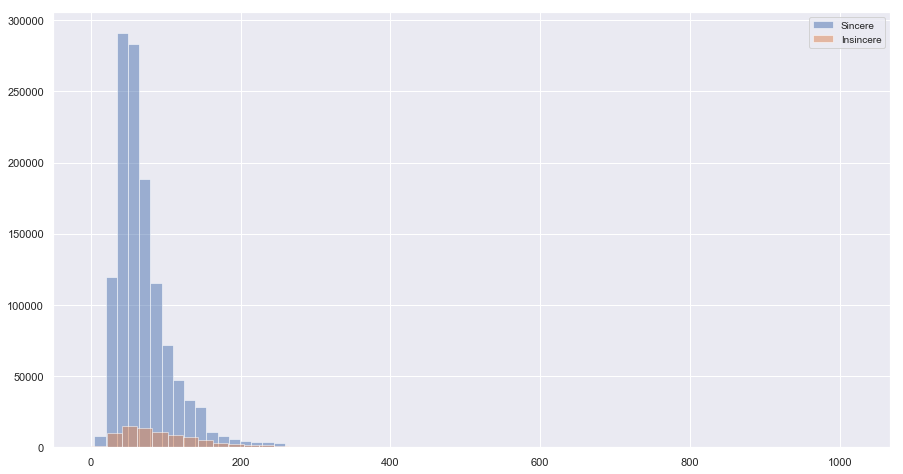

In [84]:
sincere = df_train[df_train["target"] == 0]
insincere = df_train[df_train["target"] == 1]

plt.figure(figsize = (15, 8))
plt.hist(sincere["quest_len"], bins = 50, alpha = 0.5, label = "Sincere")
plt.hist(insincere["quest_len"], bins = 50, alpha = 0.5, label = "Insincere")
plt.legend(fontsize = 10)
plt.show()


In [24]:
#thanks to https://www.kaggle.com/kaosmonkey/visualize-sincere-vs-insincere-words
class Vocabulary(object):
    
    def __init__(self):
        self.vocab = {}
        self.STOPWORDS = set()
        self.STOPWORDS = set(stopwords.words('english'))
        
    def build_vocab(self, lines):
        for line in lines:
            for word in line.split(' '):
                word = word.lower()
                if (word in self.STOPWORDS):
                    continue
                if (word not in self.vocab):
                    self.vocab[word] = 0
                self.vocab[word] +=1 

In [25]:
sincere_vocab = Vocabulary()
sincere_vocab.build_vocab(df_train[df_train['target'] == 0]['question_text'])
sincere_vocabulary = sorted(sincere_vocab.vocab.items(), reverse=True, key=lambda kv: kv[1])
for word, count in sincere_vocabulary[:20]:
    print(word, count)

best 60816
get 58731
would 57105
people 37960
like 37618
good 34827
one 28840
make 25696
think 21641
many 20788
much 20108
someone 19728
use 19250
way 18073
know 17118
take 16743
find 16508
ever 15985
want 15941
become 15781


In [26]:
insincere_vocab = Vocabulary()
insincere_vocab.build_vocab(df_train[df_train['target'] == 1]['question_text'])
insincere_vocabulary = sorted(insincere_vocab.vocab.items(), reverse=True, key=lambda kv: kv[1])
for word, count in insincere_vocabulary[:20]:
    print(word, count)

people 11036
like 5708
trump 4893
women 4757
would 4126
think 3774
many 3552
white 3351
get 3177
men 3152
indian 2984
muslims 2828
black 2672
quora 2549
americans 2478
want 2343
us 2298
hate 2171
girls 2123
indians 2122


In [27]:
df_sincere_vocab = pd.DataFrame(sincere_vocabulary, columns=['word_sincere', 'frequency'])
df_sincere_vocab.head()

,word_sincere,frequency
0,best,60816
1,get,58731
2,would,57105
3,people,37960
4,like,37618


In [34]:
df_insincere_vocab = pd.DataFrame(insincere_vocabulary, columns=['word_insincere', 'frequency'])
df_insincere_vocab.head()

,word_insincere,frequency
0,people,11036
1,like,5708
2,trump,4893
3,women,4757
4,would,4126


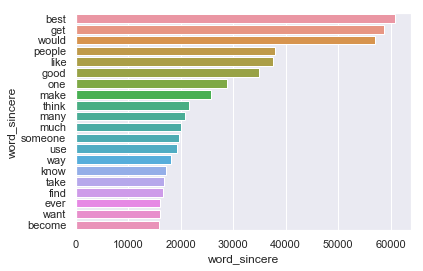

In [43]:
ax1 = sns.barplot(y='word_sincere', x='frequency', data=df_sincere_vocab[:20])
ax1.set_xlabel('word_sincere');

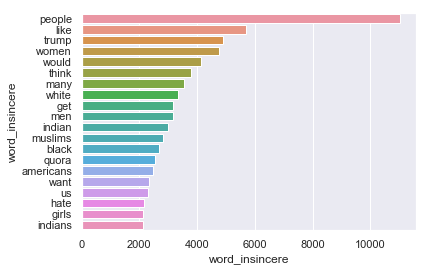

In [40]:
ax2 = sns.barplot(y='word_insincere', x='frequency', data=df_insincere_vocab[:20])
ax2.set_xlabel('word_insincere');

In [229]:
wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    random_state = 43,
                    width=800, 
                    height=400)
wordcloud

In [230]:
wordcloud.generate(text_insincere)

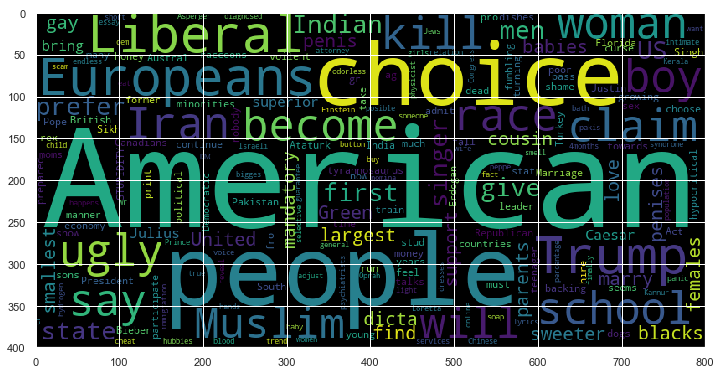

In [231]:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud);

In [44]:
df_train1.head()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


In [45]:
text = df_train.loc[:, 'question_text']
text.head()

0    How did Quebec nationalists see their province...
1    Do you have an adopted dog, how would you enco...
2    Why does velocity affect time? Does velocity a...
3    How did Otto von Guericke used the Magdeburg h...
4    Can I convert montra helicon D to a mountain b...
Name: question_text, dtype: object

In [47]:
nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])
nlp

In [63]:
%%time
spacy_docs = nlp.pipe(X_train[:10000])
spacy_docs

CPU times: user 315 µs, sys: 36 µs, total: 351 µs
Wall time: 355 µs


In [64]:
lst = list(spacy_docs)
lst[1]

Is it true that Mexicans are treated like second class citizens in the United States?

In [65]:
lst[1][12].is_stop

True

In [66]:
spacy_docs = nlp.pipe(X_train[:10000])
lemmas = [[t.lemma_ if t.lemma_ != "-PRON-" else t.text for t in lst] for lst in spacy_docs]
lemmas[:2]

[['why',
  'do',
  'you',
  'become',
  'a',
  'data',
  'science',
  'manager',
  'and',
  'stop',
  'be',
  'an',
  'individual',
  'contributor',
  '?'],
 ['be',
  'it',
  'true',
  'that',
  'mexicans',
  'be',
  'treat',
  'like',
  'second',
  'class',
  'citizen',
  'in',
  'the',
  'united',
  'states',
  '?']]

In [67]:
lemmas_as_strings = [" ".join(x) for x in lemmas]
lemmas_as_strings

['why do you become a data science manager and stop be an individual contributor ?',
 'be it true that mexicans be treat like second class citizen in the united states ?',
 'why should I not see a psychiatrist who be relate to me ?',
 'why do china want to capture other country ?',
 'what have be your good patient interaction as a doctor ?',
 'how can I remove semi - permanent blue hair dye from my naturally blonde hair ?',
 'where we find dr roy chaudhary network analysis e book in pdf ?',
 'someone from other state register a fake case of accident by my vehicle and they be ask for money as compensation for his death , so what should we do ?',
 'why the journalistic value be decline around the world as medium report bias opinion instead of fact ?',
 'as a minor , can I get test for depression without my family find out ?',
 'how do I sprout chilli seed ?',
 'how do you train a havanese puppy ?',
 'be there a reasonably repeatable path to take if you want to become a ceo of company ?',

In [69]:
cvec = CountVectorizer()
tf = cvec.fit_transform(lemmas_as_strings)
tf.shape

(10000, 12694)

In [70]:
mnb = MultinomialNB()

In [71]:
pipe = Pipeline([('cvec', cvec),('mnb', mnb)])
pipe

Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [72]:
pipe.fit(lemmas_as_strings, y_train[:10000])

Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [73]:
y_pred = pipe.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 1, 0])

In [74]:
pipe.score(X_test, y_test)

0.9403562607474646

In [75]:
cr = classification_report(y_test, y_pred)
print(cr)

             precision    recall  f1-score   support

          0       0.95      0.99      0.97    612656
          1       0.55      0.20      0.29     40405

avg / total       0.92      0.94      0.93    653061



In [86]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[606152,   6504],
       [ 32447,   7958]])

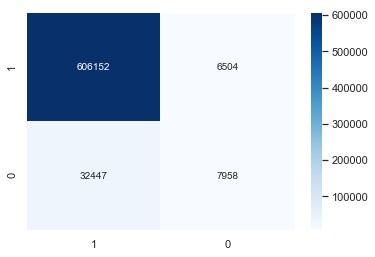

In [87]:
sns.heatmap(cm, cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique(), annot=True, fmt='.0f');

f1-score @0.29 for insincere target

**Meta Features:**

In [68]:
df_train["num_words"] = df_train["question_text"].apply(lambda x: len(str(x).split()))
df_test["num_words"] = df_test["question_text"].apply(lambda x: len(str(x).split()))
df_train["num_words"].head()

0    13
1    16
2    10
3     9
4    15
Name: num_words, dtype: int64